In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import researchpy as rp

pd.options.display.max_columns = None

import warnings
warnings.filterwarnings('ignore')

qualitative_colors = sns.light_palette("seagreen", as_cmap=True)

In [29]:
df = pd.read_pickle("../data/bikes_limpieza_sin_totales.pkl")
df.head(2)

,fecha,estacion,año,mes,festivo,dia,laborable,meteo,temperatura,sensacion_termica,humedad,velo_viento,usu_casuales,usu_registrados
0,2018-01-01,invierno,2018,ene,festivo,lun,no laborable,nublado,14.110847,18.18125,80.5833,10.749882,331,654
1,2018-01-02,invierno,2018,ene,no festivo,mar,laborable,nublado,14.902598,17.68695,69.6087,16.652113,131,670


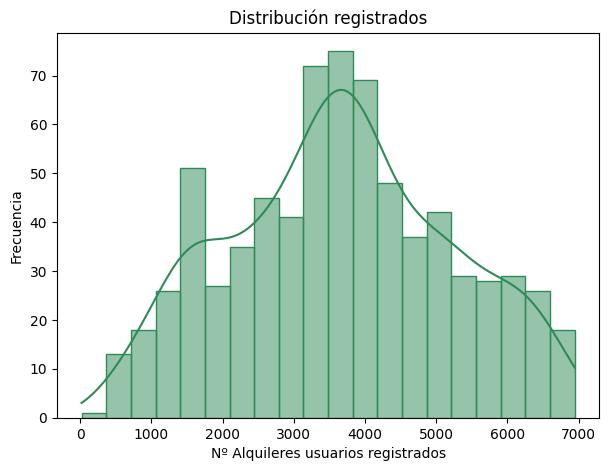

In [30]:
plt.figure(figsize=(7, 5))

sns.histplot(df["usu_registrados"], bins=20, color="seagreen", edgecolor="seagreen", kde=True)

plt.title("Distribución registrados")
plt.xlabel("Nº Alquileres usuarios registrados")
plt.ylabel("Frecuencia")
plt.savefig("../img/distribucion_resgitrados.png")

Vamos a comprobar las relaciones entre las VP numéricas y la VR:

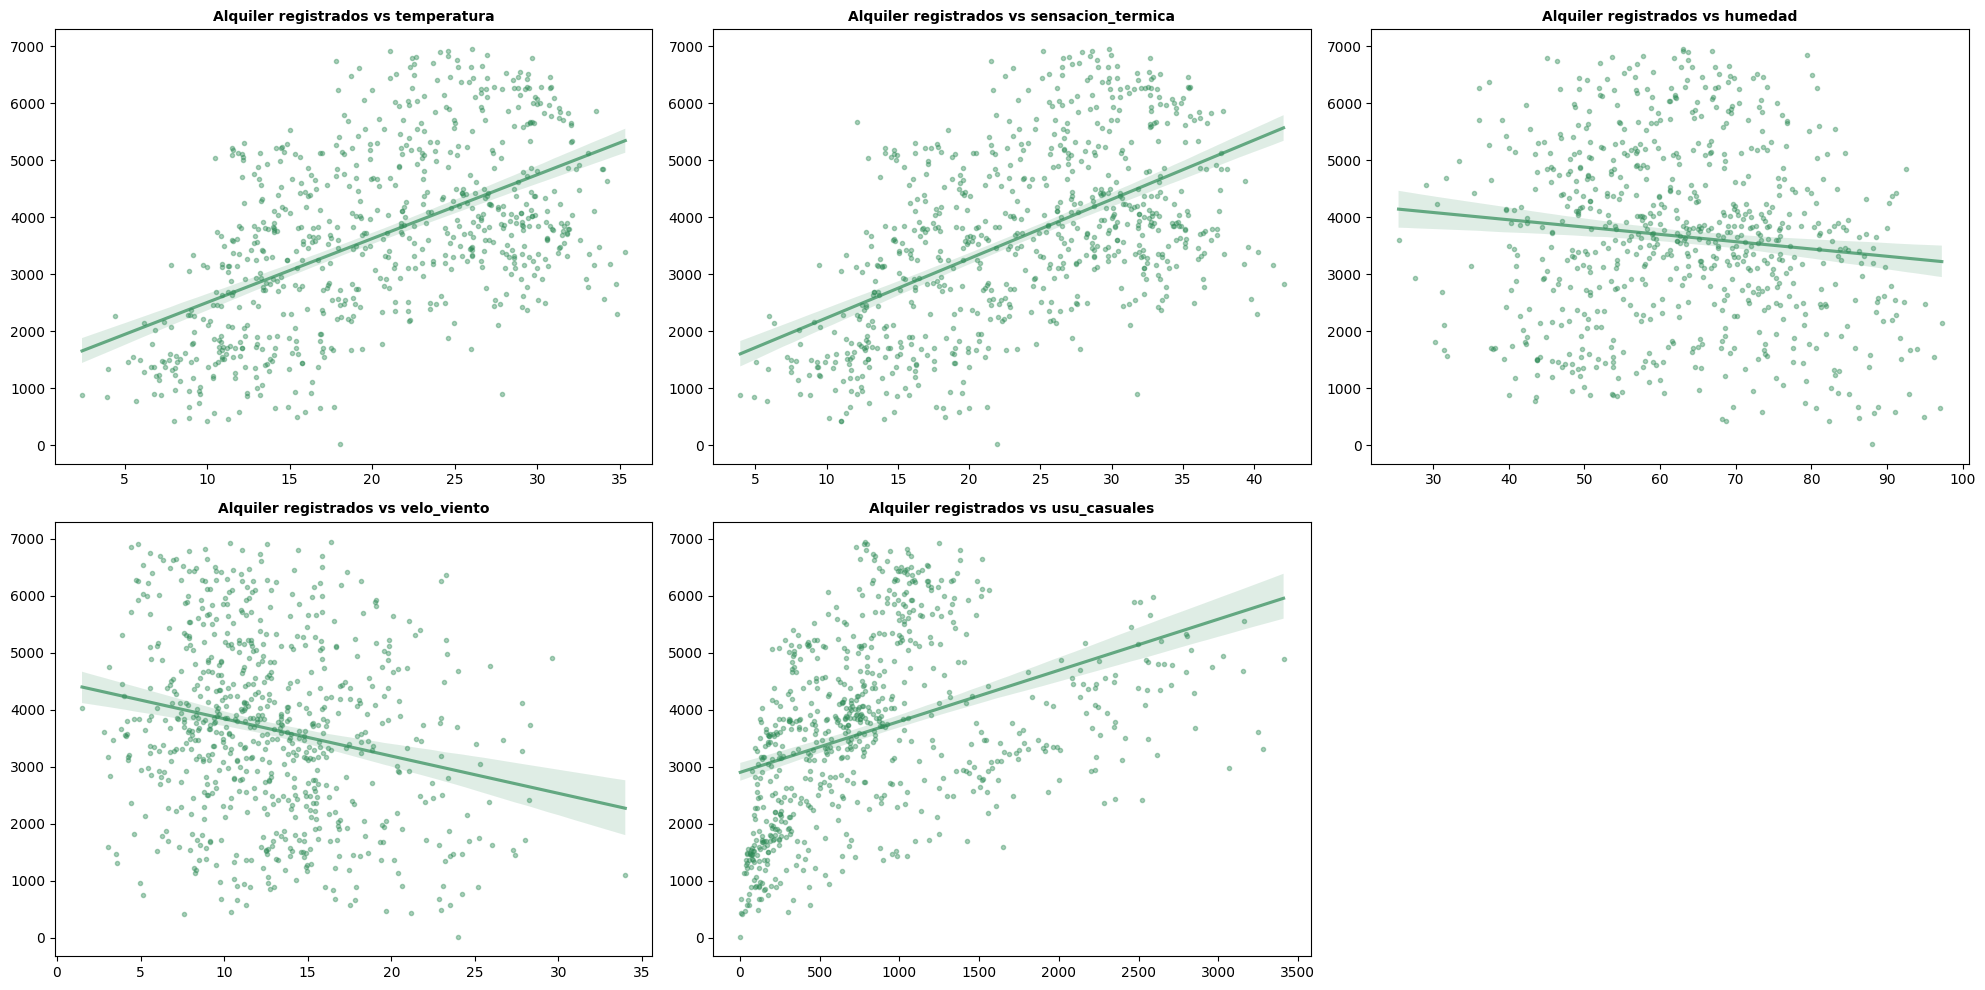

In [31]:
fig, axes = plt.subplots(2, 3, figsize = (20, 10))

axes = axes.flat

numericas = df.select_dtypes(include=np.number)

columnas_numeric = numericas.columns
columnas_numeric = columnas_numeric.drop("usu_registrados")

for i, colum in enumerate(columnas_numeric):
    sns.regplot(
        x = df[colum], 
        y = df["usu_registrados"], 
        color = "seagreen", 
        marker = ".", 
        scatter_kws = {"alpha": 0.4}, 
        line_kws = {"color": "seagreen", "alpha": 0.7 }, 
        ax = axes[i])
    
    axes[i].set_title(f"Alquiler registrados vs {colum}", fontsize = 10, fontweight = "bold")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    
fig.tight_layout()
fig.delaxes(axes[-1])
plt.savefig("../img/distribucion_numericas_registrados.png");

Comprobamos la normalidad de cada VP numérica


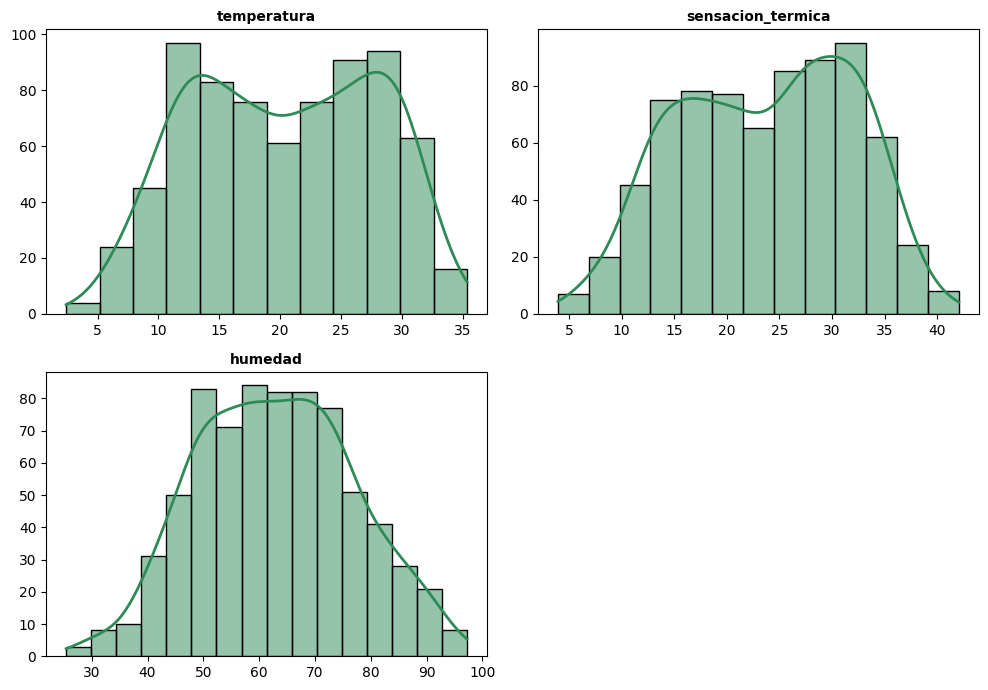

In [32]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 7))
axes = axes.flat

num = df.select_dtypes(include = np.number).columns
num = num.drop(["usu_registrados", "usu_casuales"])

for i, colum in enumerate(num):
    sns.histplot(
        data = df,
        x = colum,
        kde = True,
        color = "seagreen",
        line_kws = {"linewidth": 2},
        alpha = 0.5,
        ax = axes[i])
    axes[i].set_title(colum, fontsize = 10, fontweight = "bold")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    fig.tight_layout()
fig.delaxes(axes[-1])
plt.savefig("../img/distribucion_numericas.png");

Calculamos correlación de variables numéricas

In [33]:
df_numericas = df.select_dtypes(include = np.number)


In [34]:
df_numericas.cov()


,temperatura,sensacion_termica,humedad,velo_viento,usu_casuales,usu_registrados
temperatura,56.350979,60.674105,12.979953,-6.169865,2796.813593,6.316089e+03
sensacion_termica,60.674105,66.427517,15.639782,-7.786743,3040.124429,6.911517e+03
humedad,12.979953,15.639782,195.738171,-16.628026,-852.678361,-2.505269e+03
velo_viento,-6.169865,-7.786743,-16.628026,26.996761,-599.212506,-1.766034e+03
usu_casuales,2796.813593,3040.124429,-852.678361,-599.212506,471254.618141,4.220196e+05
usu_registrados,6316.089253,6911.516931,-2505.268579,-1766.034199,422019.595513,2.432847e+06


In [35]:
df_numericas.corr()


,temperatura,sensacion_termica,humedad,velo_viento,usu_casuales,usu_registrados
temperatura,1.000000,0.991696,0.123590,-0.158186,0.542731,0.539436
sensacion_termica,0.991696,1.000000,0.137157,-0.183876,0.543362,0.543678
humedad,0.123590,0.137157,1.000000,-0.228743,-0.088781,-0.114805
velo_viento,-0.158186,-0.183876,-0.228743,1.000000,-0.167995,-0.217914
usu_casuales,0.542731,0.543362,-0.088781,-0.167995,1.000000,0.394137
usu_registrados,0.539436,0.543678,-0.114805,-0.217914,0.394137,1.000000


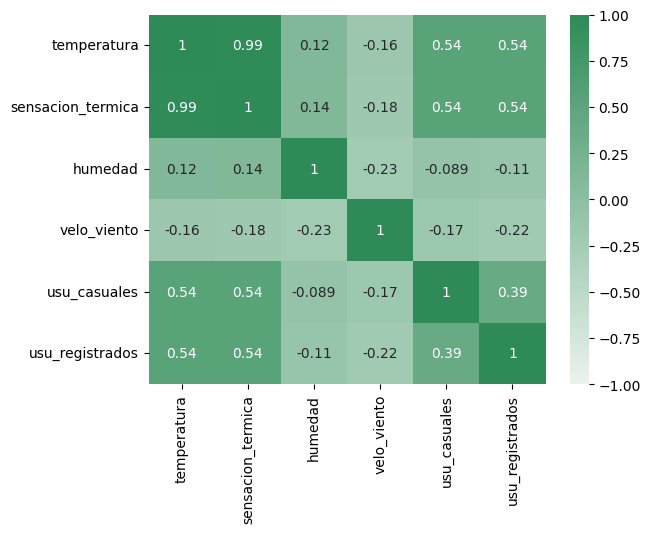

In [36]:
sns.heatmap(df_numericas.corr(), 
            cmap = qualitative_colors, 
           annot = True, vmax = 1, vmin = -1);
plt.savefig('../img/heatmap_correl.png', dpi = 300)

Vistas estas relaciones entre las variables numéricas, puesto que temperatura y sensación térmica correlacionan muy alto y parece que ambas correlacionan en la misma medida con el resto de variables numéricas, vamos a eliminar la temperatura en los análisis de nuestro modelo predictivo.

Vamos ahora a ver cómo se distribuye la VR según las VP categóricas:

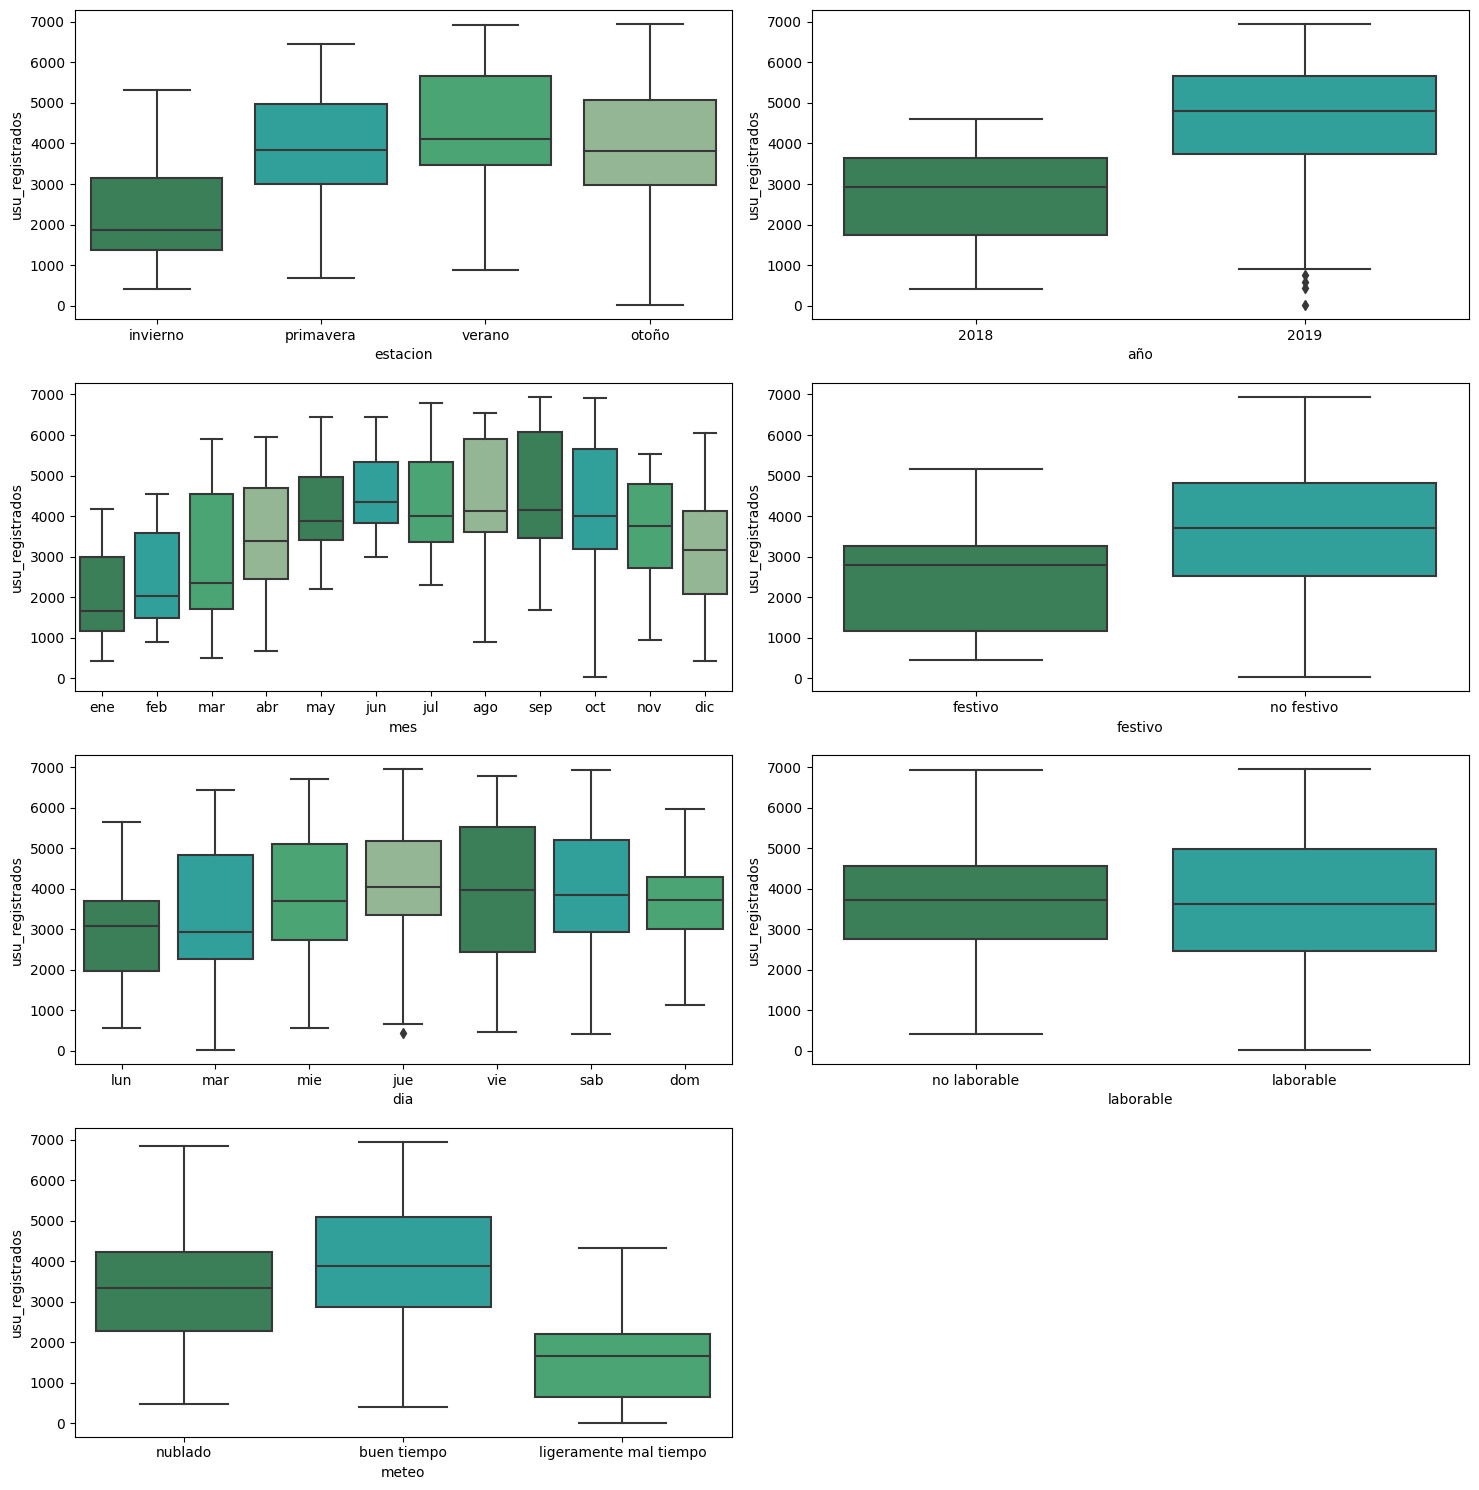

In [37]:
categoricas = df.select_dtypes(include=["object", "category"])
colores = ['seagreen', 'lightseagreen', 'mediumseagreen', 'darkseagreen']
fig, axes = plt.subplots(4, 2, figsize=(15,15))
axes = axes.flat
for indice, columna in enumerate(categoricas.columns):
    sns.boxplot(x = categoricas[columna], y = 'usu_registrados', data = df, ax = axes[indice], palette = colores);
plt.tight_layout()
fig.delaxes(axes[-1])
plt.savefig("../img/distribucion_categ_registrados.png")

- No tiene orden variables =  laborable
- Tienen orden variables = meteo, mes, estacion, festivo, dia, año

Independencia variables categóricas

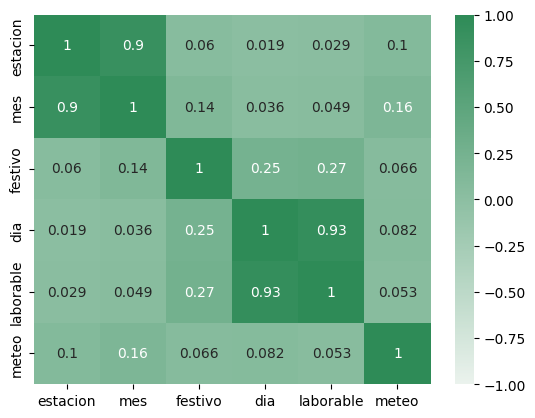

In [38]:
categoricas_col = df.select_dtypes(include= ["object", "bool"]).columns
df_chis = pd.DataFrame(columns= categoricas_col, index = categoricas_col)

from itertools import combinations
combinaciones = list(combinations(categoricas_col,2))
for i in combinaciones:
    crosstab, test_results, expected = rp.crosstab(df[i[0]], df[i[1]],
                                               test= "chi-square",
                                               expected_freqs= True,
                                               prop= "cell")
    df_chis.loc[i[0], i[1]] = test_results.loc[2, 'results']
    df_chis.loc[i[1], i[0]] = test_results.loc[2, 'results']
    df_chis.loc[i[0], i[0]] = 1.00
    df_chis.loc[i[1], i[1]] = 1.00
df_chis = df_chis.astype('float')
df_chis.dtypes
cmap = sns.diverging_palette(349, 250, sep=150, as_cmap=True)
sns.heatmap(df_chis,
           cmap = qualitative_colors,
           annot = True,
           vmin= -1,
           vmax= 1)
plt.savefig("../img/heatmap_categoricas.png");

**NOTA: para los cálculos de predicciones NO tendremos en cuenta las columnas estación y laborable como variables predictoras por ser redundantes con mes y día.** 